In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(463113, 198)
(463113, 1)
validation
(87055, 198)
(87055, 1)
test
(43409, 198)
(43409, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 892929 (3.41 MB)


Trainable params: 892929 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:01 - loss: 0.0450 - STD: 9.4307e-05 - MAE: 0.1929

 6/47 [==>...........................] - ETA: 0s - loss: 0.0244 - STD: 6.0407e-05 - MAE: 0.1206  

11/47 [======>.......................] - ETA: 0s - loss: 0.0219 - STD: 4.6304e-05 - MAE: 0.1113

16/47 [=========>....................] - ETA: 0s - loss: 0.0194 - STD: 4.4709e-05 - MAE: 0.1069

21/47 [============>.................] - ETA: 0s - loss: 0.0179 - STD: 4.5668e-05 - MAE: 0.1037

22/47 [=============>................] - ETA: 1s - loss: 0.0179 - STD: 4.5801e-05 - MAE: 0.1028

26/47 [===============>..............] - ETA: 0s - loss: 0.0171 - STD: 4.6464e-05 - MAE: 0.0997

30/47 [==================>...........] - ETA: 0s - loss: 0.0165 - STD: 4.8218e-05 - MAE: 0.0975

35/47 [=====================>........] - ETA: 0s - loss: 0.0159 - STD: 5.2267e-05 - MAE: 0.0962

40/47 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 5.6701e-05 - MAE: 0.0952

45/47 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 6.0689e-05 - MAE: 0.0940

47/47 [==============================] - 3s 41ms/step - loss: 0.0149 - STD: 6.2443e-05 - MAE: 0.0935 - val_loss: 0.0142 - val_STD: 9.2417e-05 - val_MAE: 0.0920


Epoch 2/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0118 - STD: 1.0725e-04 - MAE: 0.0834

 6/47 [==>...........................] - ETA: 0s - loss: 0.0119 - STD: 1.1763e-04 - MAE: 0.0855

10/47 [=====>........................] - ETA: 0s - loss: 0.0119 - STD: 1.2406e-04 - MAE: 0.0858

15/47 [========>.....................] - ETA: 0s - loss: 0.0120 - STD: 1.3060e-04 - MAE: 0.0855

20/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 1.3826e-04 - MAE: 0.0851

24/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 1.4545e-04 - MAE: 0.0853

29/47 [=================>............] - ETA: 0s - loss: 0.0120 - STD: 1.5500e-04 - MAE: 0.0854

34/47 [====================>.........] - ETA: 0s - loss: 0.0120 - STD: 1.6470e-04 - MAE: 0.0853

39/47 [=======================>......] - ETA: 0s - loss: 0.0120 - STD: 1.7540e-04 - MAE: 0.0852

44/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 1.8708e-04 - MAE: 0.0853

47/47 [==============================] - 1s 15ms/step - loss: 0.0120 - STD: 1.9443e-04 - MAE: 0.0852 - val_loss: 0.0140 - val_STD: 2.7416e-04 - val_MAE: 0.0923


Epoch 3/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0121 - STD: 3.1647e-04 - MAE: 0.0857

 6/47 [==>...........................] - ETA: 0s - loss: 0.0121 - STD: 3.3677e-04 - MAE: 0.0853

10/47 [=====>........................] - ETA: 0s - loss: 0.0120 - STD: 3.5283e-04 - MAE: 0.0852

15/47 [========>.....................] - ETA: 0s - loss: 0.0121 - STD: 3.7563e-04 - MAE: 0.0854

20/47 [===========>..................] - ETA: 0s - loss: 0.0120 - STD: 4.0034e-04 - MAE: 0.0852

25/47 [==============>...............] - ETA: 0s - loss: 0.0120 - STD: 4.2734e-04 - MAE: 0.0851

30/47 [==================>...........] - ETA: 0s - loss: 0.0120 - STD: 4.5737e-04 - MAE: 0.0850

35/47 [=====================>........] - ETA: 0s - loss: 0.0120 - STD: 4.9240e-04 - MAE: 0.0850

40/47 [========================>.....] - ETA: 0s - loss: 0.0120 - STD: 5.3222e-04 - MAE: 0.0850

45/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 5.7672e-04 - MAE: 0.0849

47/47 [==============================] - 1s 15ms/step - loss: 0.0120 - STD: 5.9614e-04 - MAE: 0.0849 - val_loss: 0.0139 - val_STD: 9.3779e-04 - val_MAE: 0.0919


Epoch 4/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0115 - STD: 0.0011 - MAE: 0.0835

 6/47 [==>...........................] - ETA: 0s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0843

11/47 [======>.......................] - ETA: 0s - loss: 0.0119 - STD: 0.0013 - MAE: 0.0848

16/47 [=========>....................] - ETA: 0s - loss: 0.0119 - STD: 0.0014 - MAE: 0.0848

21/47 [============>.................] - ETA: 0s - loss: 0.0119 - STD: 0.0016 - MAE: 0.0846

26/47 [===============>..............] - ETA: 0s - loss: 0.0119 - STD: 0.0018 - MAE: 0.0846

31/47 [==================>...........] - ETA: 0s - loss: 0.0118 - STD: 0.0020 - MAE: 0.0845

36/47 [=====================>........] - ETA: 0s - loss: 0.0118 - STD: 0.0023 - MAE: 0.0843

41/47 [=========================>....] - ETA: 0s - loss: 0.0117 - STD: 0.0027 - MAE: 0.0842

46/47 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.0033 - MAE: 0.0840

47/47 [==============================] - 1s 14ms/step - loss: 0.0116 - STD: 0.0034 - MAE: 0.0840 - val_loss: 0.0128 - val_STD: 0.0085 - val_MAE: 0.0895


Epoch 5/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0114 - STD: 0.0098 - MAE: 0.0840

 5/47 [==>...........................] - ETA: 0s - loss: 0.0109 - STD: 0.0112 - MAE: 0.0821

10/47 [=====>........................] - ETA: 0s - loss: 0.0107 - STD: 0.0135 - MAE: 0.0812

15/47 [========>.....................] - ETA: 0s - loss: 0.0105 - STD: 0.0163 - MAE: 0.0801

20/47 [===========>..................] - ETA: 0s - loss: 0.0102 - STD: 0.0200 - MAE: 0.0789

25/47 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 0.0242 - MAE: 0.0777

30/47 [==================>...........] - ETA: 0s - loss: 0.0096 - STD: 0.0286 - MAE: 0.0766

34/47 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0321 - MAE: 0.0757

38/47 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.0353 - MAE: 0.0749

43/47 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0388 - MAE: 0.0740

47/47 [==============================] - 1s 14ms/step - loss: 0.0090 - STD: 0.0411 - MAE: 0.0735 - val_loss: 0.0096 - val_STD: 0.0554 - val_MAE: 0.0749


Epoch 6/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0079 - STD: 0.0638 - MAE: 0.0667

 6/47 [==>...........................] - ETA: 0s - loss: 0.0078 - STD: 0.0634 - MAE: 0.0671

11/47 [======>.......................] - ETA: 0s - loss: 0.0079 - STD: 0.0626 - MAE: 0.0672

16/47 [=========>....................] - ETA: 0s - loss: 0.0078 - STD: 0.0624 - MAE: 0.0670

21/47 [============>.................] - ETA: 0s - loss: 0.0078 - STD: 0.0626 - MAE: 0.0669

26/47 [===============>..............] - ETA: 0s - loss: 0.0078 - STD: 0.0628 - MAE: 0.0669

31/47 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.0630 - MAE: 0.0668

36/47 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0632 - MAE: 0.0668

41/47 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0634 - MAE: 0.0668

46/47 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0636 - MAE: 0.0667

47/47 [==============================] - 1s 14ms/step - loss: 0.0077 - STD: 0.0636 - MAE: 0.0667 - val_loss: 0.0095 - val_STD: 0.0562 - val_MAE: 0.0754


Epoch 7/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0078 - STD: 0.0639 - MAE: 0.0663

 6/47 [==>...........................] - ETA: 0s - loss: 0.0076 - STD: 0.0640 - MAE: 0.0660

11/47 [======>.......................] - ETA: 0s - loss: 0.0076 - STD: 0.0642 - MAE: 0.0659

16/47 [=========>....................] - ETA: 0s - loss: 0.0076 - STD: 0.0642 - MAE: 0.0658

21/47 [============>.................] - ETA: 0s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0659

26/47 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.0644 - MAE: 0.0660

31/47 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0643 - MAE: 0.0661

36/47 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.0644 - MAE: 0.0660

41/47 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0647 - MAE: 0.0659

46/47 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0648 - MAE: 0.0659

47/47 [==============================] - 1s 14ms/step - loss: 0.0076 - STD: 0.0648 - MAE: 0.0659 - val_loss: 0.0096 - val_STD: 0.0556 - val_MAE: 0.0739


Epoch 8/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0075 - STD: 0.0631 - MAE: 0.0638

 6/47 [==>...........................] - ETA: 0s - loss: 0.0076 - STD: 0.0650 - MAE: 0.0656

11/47 [======>.......................] - ETA: 0s - loss: 0.0075 - STD: 0.0653 - MAE: 0.0655

16/47 [=========>....................] - ETA: 0s - loss: 0.0075 - STD: 0.0655 - MAE: 0.0652

21/47 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.0656 - MAE: 0.0651

26/47 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.0658 - MAE: 0.0650

30/47 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0660 - MAE: 0.0650

34/47 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0660 - MAE: 0.0650

39/47 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.0662 - MAE: 0.0649

44/47 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0662 - MAE: 0.0648

47/47 [==============================] - 1s 14ms/step - loss: 0.0074 - STD: 0.0663 - MAE: 0.0648 - val_loss: 0.0093 - val_STD: 0.0587 - val_MAE: 0.0730


Epoch 9/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0072 - STD: 0.0664 - MAE: 0.0635

 6/47 [==>...........................] - ETA: 0s - loss: 0.0074 - STD: 0.0664 - MAE: 0.0644

11/47 [======>.......................] - ETA: 0s - loss: 0.0074 - STD: 0.0667 - MAE: 0.0644

16/47 [=========>....................] - ETA: 0s - loss: 0.0073 - STD: 0.0669 - MAE: 0.0642

21/47 [============>.................] - ETA: 0s - loss: 0.0073 - STD: 0.0670 - MAE: 0.0641

26/47 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.0670 - MAE: 0.0641

31/47 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0640

36/47 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0671 - MAE: 0.0640

41/47 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0673 - MAE: 0.0639

46/47 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0675 - MAE: 0.0638

47/47 [==============================] - 1s 14ms/step - loss: 0.0072 - STD: 0.0675 - MAE: 0.0637 - val_loss: 0.0091 - val_STD: 0.0630 - val_MAE: 0.0723


Epoch 10/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0686 - MAE: 0.0624

 6/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0675 - MAE: 0.0627

11/47 [======>.......................] - ETA: 0s - loss: 0.0070 - STD: 0.0685 - MAE: 0.0628

16/47 [=========>....................] - ETA: 0s - loss: 0.0070 - STD: 0.0687 - MAE: 0.0628

21/47 [============>.................] - ETA: 0s - loss: 0.0070 - STD: 0.0688 - MAE: 0.0628

25/47 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.0689 - MAE: 0.0628

29/47 [=================>............] - ETA: 0s - loss: 0.0070 - STD: 0.0691 - MAE: 0.0626

34/47 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0692 - MAE: 0.0627

38/47 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0692 - MAE: 0.0627

43/47 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0694 - MAE: 0.0626

47/47 [==============================] - 1s 14ms/step - loss: 0.0070 - STD: 0.0695 - MAE: 0.0626 - val_loss: 0.0093 - val_STD: 0.0694 - val_MAE: 0.0734


Epoch 11/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0742 - MAE: 0.0631

 6/47 [==>...........................] - ETA: 0s - loss: 0.0070 - STD: 0.0704 - MAE: 0.0630

11/47 [======>.......................] - ETA: 0s - loss: 0.0070 - STD: 0.0700 - MAE: 0.0630

15/47 [========>.....................] - ETA: 0s - loss: 0.0070 - STD: 0.0695 - MAE: 0.0628

19/47 [===========>..................] - ETA: 0s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0626

24/47 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.0705 - MAE: 0.0625

29/47 [=================>............] - ETA: 0s - loss: 0.0069 - STD: 0.0705 - MAE: 0.0624

34/47 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.0707 - MAE: 0.0623

39/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0707 - MAE: 0.0621

44/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0708 - MAE: 0.0621

47/47 [==============================] - 1s 14ms/step - loss: 0.0069 - STD: 0.0709 - MAE: 0.0621 - val_loss: 0.0093 - val_STD: 0.0685 - val_MAE: 0.0713


Epoch 12/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0712 - MAE: 0.0602

 5/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0722 - MAE: 0.0612

10/47 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0723 - MAE: 0.0619

14/47 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0715 - MAE: 0.0617

19/47 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0718 - MAE: 0.0620

24/47 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0716 - MAE: 0.0619

29/47 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0713 - MAE: 0.0618

34/47 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0618

39/47 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0715 - MAE: 0.0617

44/47 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0716 - MAE: 0.0617

47/47 [==============================] - 1s 14ms/step - loss: 0.0068 - STD: 0.0716 - MAE: 0.0617 - val_loss: 0.0094 - val_STD: 0.0718 - val_MAE: 0.0728


Epoch 13/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0740 - MAE: 0.0616

 6/47 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0728 - MAE: 0.0613

11/47 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0612

16/47 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0612

21/47 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0611

25/47 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0609

30/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0729 - MAE: 0.0609

35/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0609

39/47 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0609

44/47 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0609

47/47 [==============================] - 1s 15ms/step - loss: 0.0067 - STD: 0.0729 - MAE: 0.0609 - val_loss: 0.0093 - val_STD: 0.0693 - val_MAE: 0.0714


Epoch 14/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0607

 5/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0610

10/47 [=====>........................] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0610

14/47 [=======>......................] - ETA: 0s - loss: 0.0067 - STD: 0.0725 - MAE: 0.0610

18/47 [==========>...................] - ETA: 0s - loss: 0.0067 - STD: 0.0726 - MAE: 0.0610

22/47 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.0727 - MAE: 0.0609

27/47 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0729 - MAE: 0.0610

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0729 - MAE: 0.0609

35/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0608

40/47 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0729 - MAE: 0.0607

45/47 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0608

47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0730 - MAE: 0.0608 - val_loss: 0.0095 - val_STD: 0.0725 - val_MAE: 0.0726


Epoch 15/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0065 - STD: 0.0733 - MAE: 0.0602

 6/47 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0732 - MAE: 0.0604

11/47 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0604

16/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0607

21/47 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0734 - MAE: 0.0606

26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0737 - MAE: 0.0607

31/47 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0732 - MAE: 0.0608

36/47 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0612

41/47 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0613

46/47 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0724 - MAE: 0.0613

47/47 [==============================] - 1s 14ms/step - loss: 0.0067 - STD: 0.0723 - MAE: 0.0613 - val_loss: 0.0094 - val_STD: 0.0691 - val_MAE: 0.0716


Epoch 16/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0068 - STD: 0.0714 - MAE: 0.0608

 6/47 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0736 - MAE: 0.0614

11/47 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0722 - MAE: 0.0612

16/47 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0723 - MAE: 0.0609

21/47 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.0728 - MAE: 0.0609

26/47 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0727 - MAE: 0.0608

31/47 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0608

36/47 [=====================>........] - ETA: 0s - loss: 0.0066 - STD: 0.0730 - MAE: 0.0607

41/47 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0606

46/47 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0606

47/47 [==============================] - 1s 14ms/step - loss: 0.0066 - STD: 0.0731 - MAE: 0.0606 - val_loss: 0.0094 - val_STD: 0.0726 - val_MAE: 0.0723


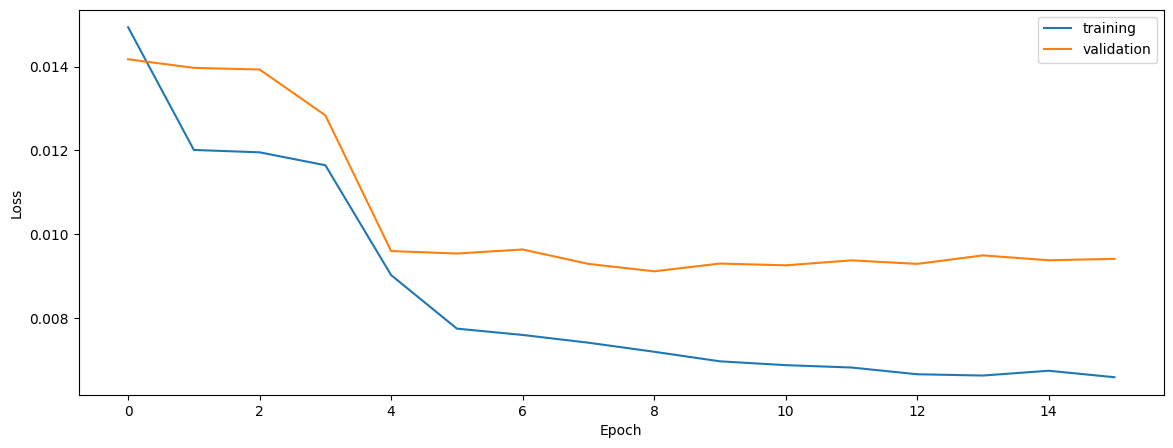

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6440402039826911
0.5853423647822267
0.6157418082776402


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6425230713082475
0.6482011307093442
0.616746150493466


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6479657319509569
0.652086709197723
0.635694371688236


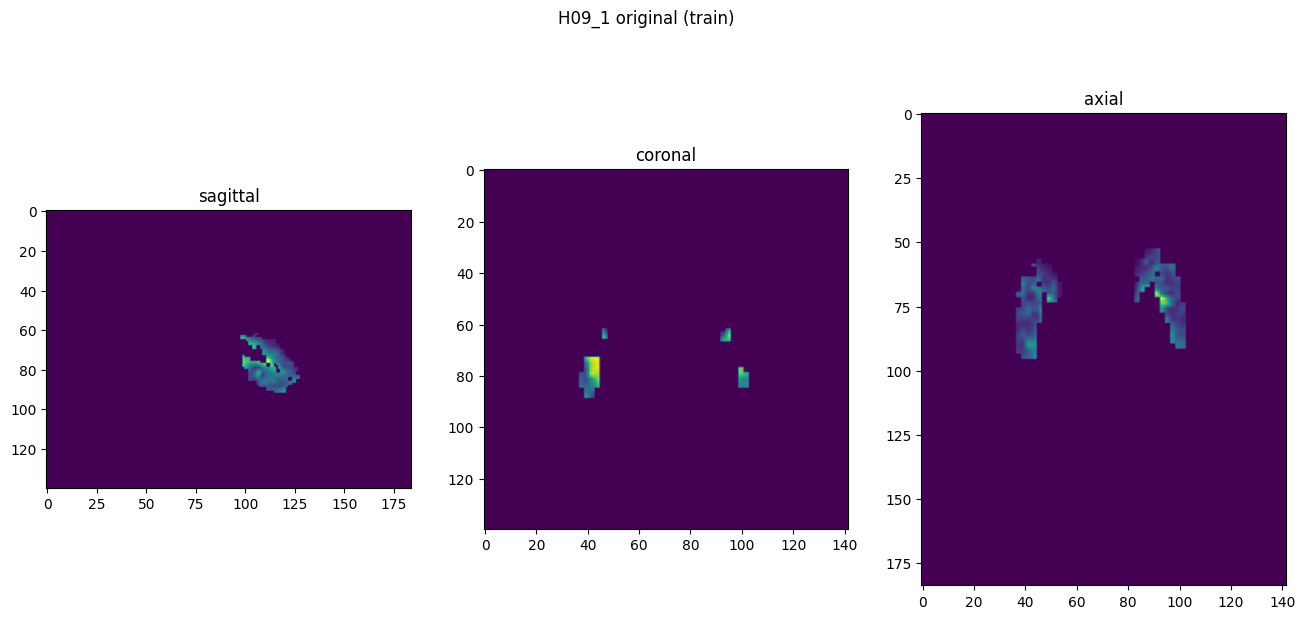

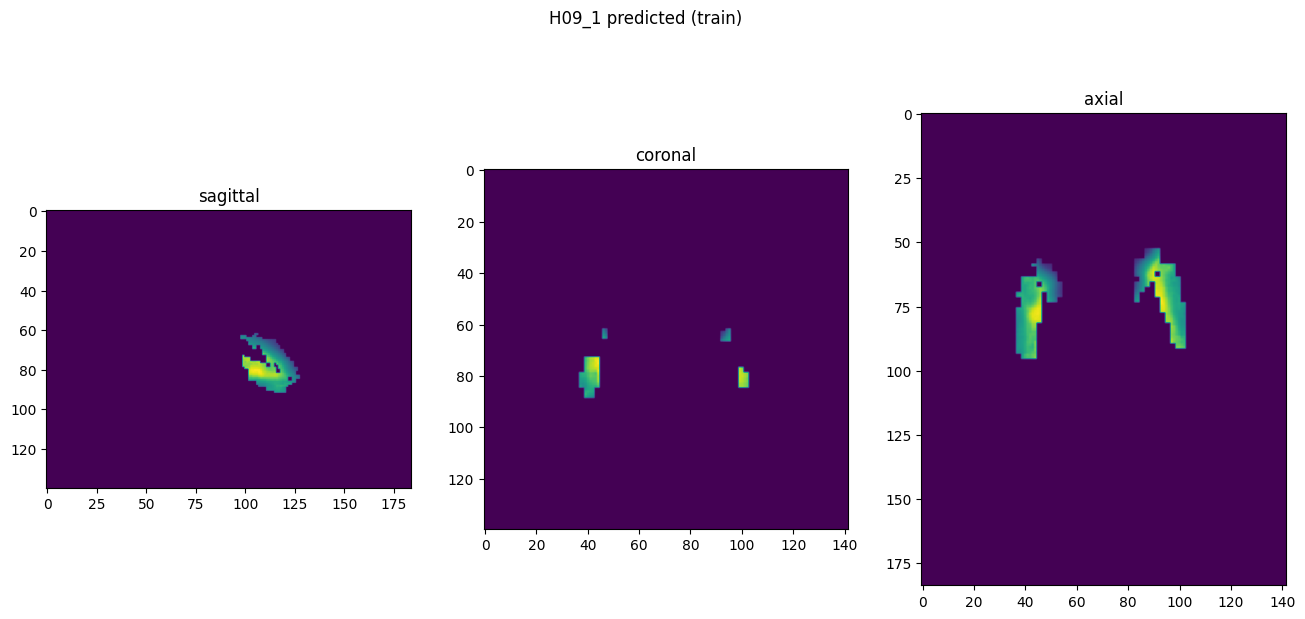

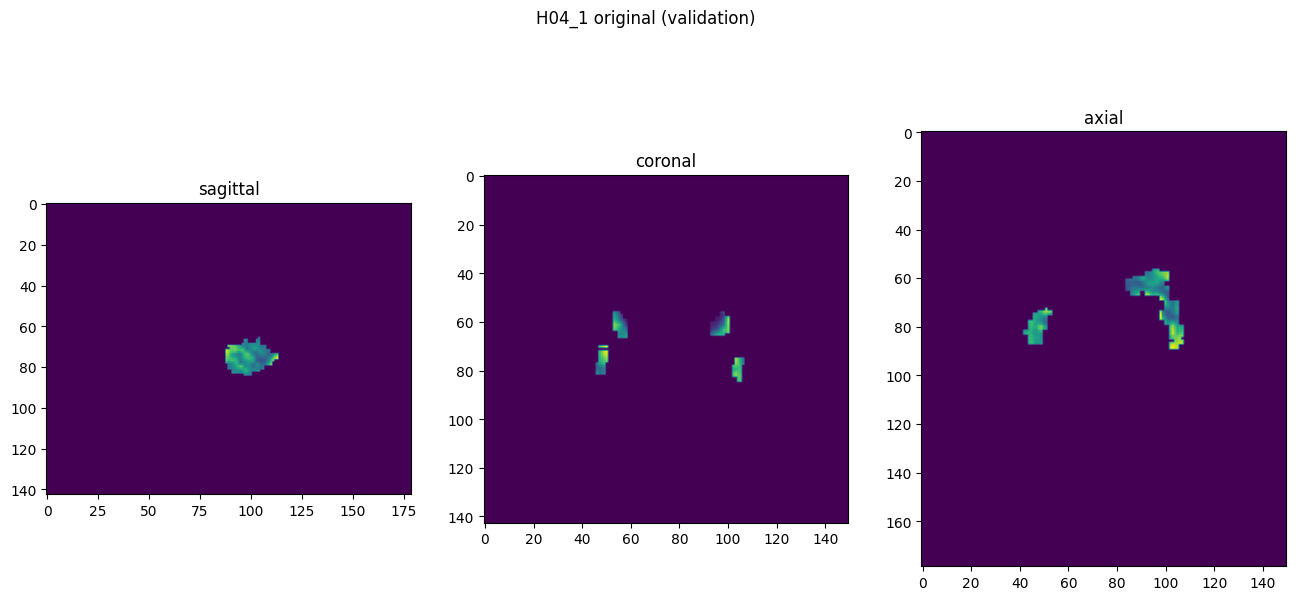

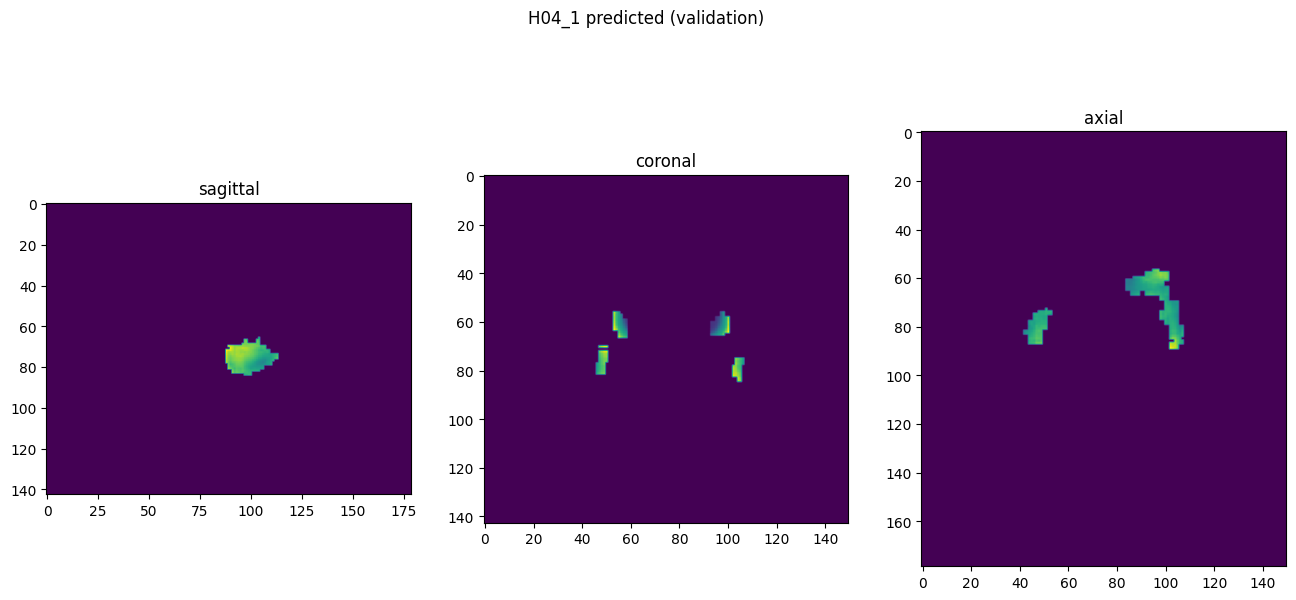

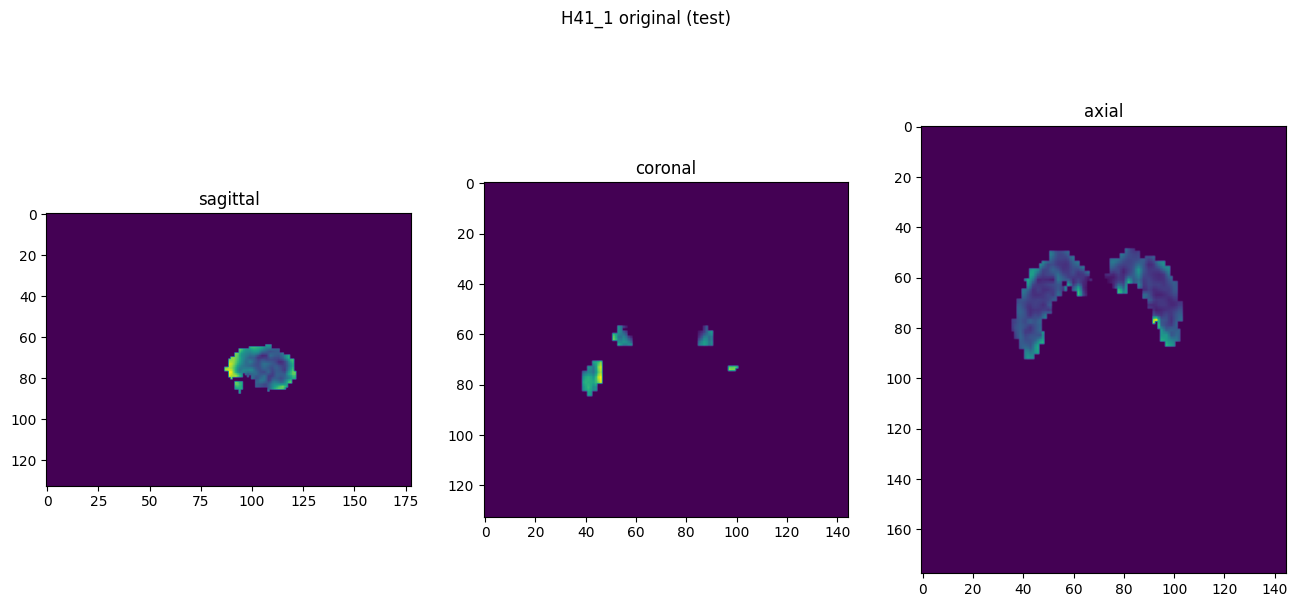

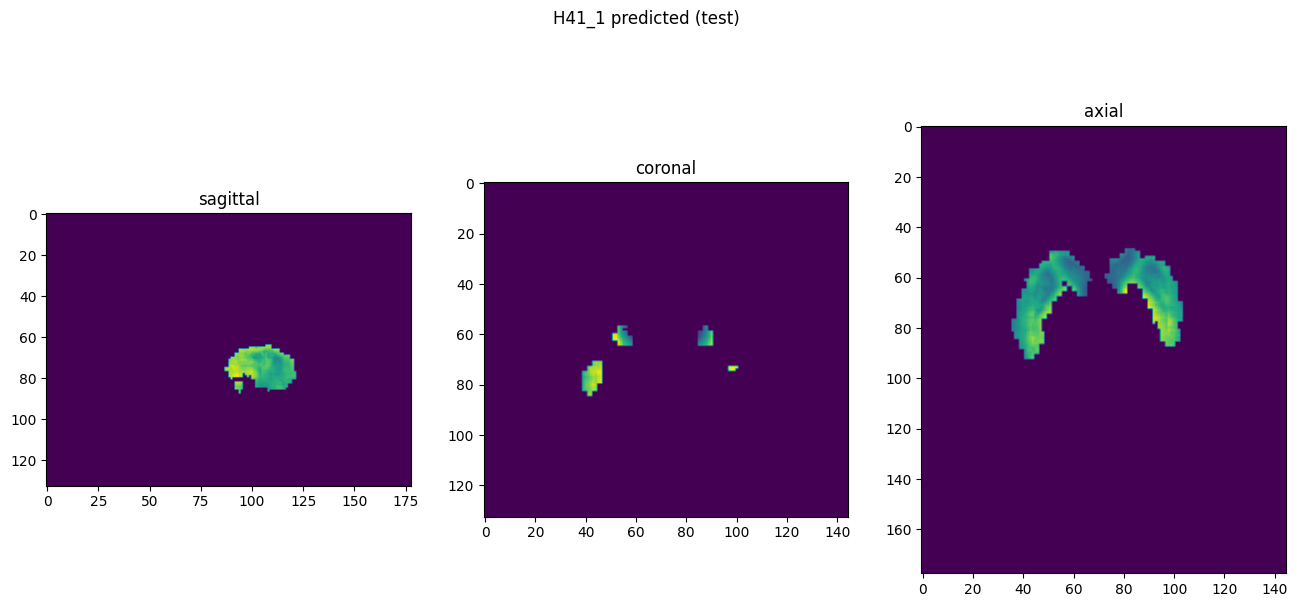

In [10]:
showResults(model, gen, threshold=None, background=False)